## Import NBER graph and add department data

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import scipy.stats as stats
import nltk.metrics as nm
import editdistance
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Load NBER Graph from File
# NBER graph contains coauthorship edges annotated with JEL codes 
path = '../save/nber.graphml'
G = nx.read_graphml(path)

In [ ]:
## Merge in Departments (scraped from REPEC)
department = pd.read_csv('../../../work_erica/EconIdeaNetwork/save/REPEC_Paper_Info.csv', delimiter=',')
department = department.drop_duplicates()

In [ ]:
department['authorClean'] = department.Author.apply(lambda x: x.replace(',','').split(' '))
department['authorClean'] = department['authorClean'].apply(lambda x: x[1] + x[0])

In [ ]:
# HACK: Drop duplicates by taking first institution 
department = department.groupby('authorClean').first().reset_index()

In [ ]:
# Manually Check for matches using Levenstein Distance (tolerance = 2)

authorDF = []

def getAuthorMatches(author):

    matches = pd.DataFrame(ndf.author[ndf.author.apply(lambda x: editdistance.eval(x, author)) < 2])
    matches['repecAuthor'] = author

    return matches

In [ ]:
# Get list of Author Matches

%%time
deptMatches = department.authorClean.apply(getAuthorMatches)
deptMatches = pd.concat(list(deptMatches))

In [ ]:
# Fix Author Errors in NBER by merging
# Nodes with wrong names

s = deptMatches.groupby('repecAuthor').size()
nberAuthorErrors = s[s > 1].index

for currAuthor in nberAuthorErrors:

    prevAuthorNames = deptMatches[deptMatches.repecAuthor == currAuthor].author.values

    # For each prev name, collect all edges
    # then delete node

    allPrevEdges = []

    for prevName in prevAuthorNames:

        prevEdges = G.edges(prevName)
        prevEdges = [x[1] for x in prevEdges]
        allPrevEdges = allPrevEdges + prevEdges

        G.remove_node(prevName)

    # Create new node with full set of edges

    for target in allPrevEdges:
        G.add_edge(prevAuthorNames[0], target)

In [ ]:
# Merge Department Affiliations onto Author Matches
authDept = pd.merge(deptMatches, department, how='left', left_on='repecAuthor', right_on='authorClean')

In [ ]:
authDept

In [ ]:
# Add department affiliations to G
for author in authDept
    authDept["Institution"]
    
end

In [ ]:
# Basic full-graph summary stats
degree_dist = nx.degree_histogram(G)


## Summarize a list of subgraphs 

In [311]:
# utility functions

def getExternalDegreeDist(subgraph, graph):
    degs = np.array(nx.degree(graph, subgraph.nodes()).values()) - \
    np.array(nx.degree(subgraph, subgraph.nodes()).values())
    
    return np.histogram(degs, bins=max(degs))[0]

In [290]:
def getAvgExternalDegree(subgraph, graph):
    gdegree = np.array(nx.degree(graph, subgraph.nodes()).values())
    sgdegree = np.array(nx.degree(subgraph, subgraph.nodes()).values())
    return np.mean(gdegree - sgdegree)

In [312]:
# Summarize a set 
# For each graph in a list, compute Avg Degree, Avg Betweenness Centrality, 
# Number of Components,
# Number of Nodes, Longest Shortest Path, Total # of Papers, 
# Avg # of Papers per author, % of Papers within Dept, Rank

# For example, "kind" could be 'Institution', "entries" would be a list of institutions
def summGraphList(kind, entries, subgraphList, graph):
    df = pd.DataFrame()
    df['id']        = entries
    
    df['Subgraph']  = df['id'].apply(lambda x: subgraphList[x])
    df['nNodes'] = df.Subgraph.apply(lambda x: len(x.nodes()))
    df['nWithinEdges'] = df.Subgraph.apply(lambda x: len(x.edges()))
    df['nExternalEdges'] = df.Subgraph.apply(lambda x: len(x.edges()))
        
    # degree distribution within the dept
    df['AvgWithinDegree'] = df.Subgraph.apply(lambda x: \
                                         np.mean(nx.degree(x, x.nodes()).values()))

    
    df['WithinDegreeDist'] = df.Subgraph.apply(lambda x: nx.degree_histogram(x))
    df['WithinDegreeSkewness'] = df.WithinDegreeDist.apply(lambda x: stats.skew(x))
    
    # avg degree outside the department
    df['AvgExternalDegree'] = df.Subgraph.apply(lambda x: getAvgExternalDegree(x, graph))
    
    df['ExternalDegreeDist'] = df.Subgraph.apply(lambda x: getExternalDegreeDist(x, graph))
    df['ExternalDegreeSkewness'] = df.ExternalDegreeDist.apply(lambda x: stats.skew(x))
    
    # Drop empty entries
    df = df[df.nNodes != 0]

    # Summary stats for connected components
    df['nCC'] = df.Subgraph.apply(lambda x: \
                                   len([c for c in nx.connected_components(x)]))
    df['AvgSizeCC'] = df.Subgraph.apply(lambda x: \
                                         np.mean([len(c) for c in nx.connected_components(x)]))
    df['MaxSizeCC'] = df.Subgraph.apply(lambda x: \
                                         np.max([len(c) for c in nx.connected_components(x)]))
  
    # betweenness - gonna be very computationally intensive
    # df['BetweennessDist'] = df.Graph.apply(lambda x: nx.betweenness_centrality(x))
    
    # rename id column 
    df.rename(columns={'id': kind})

    return df

In [315]:
sgl = summGraphList('bigJel', list(bigJels), jelGraphs, G)
#stats.skew?

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


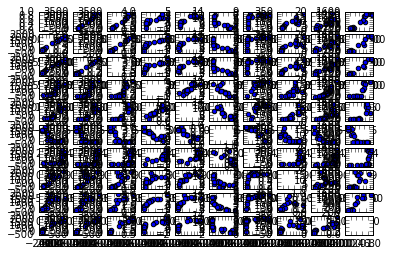

In [337]:
cols = [c for c in sgl.columns if 'id' not in c and 'Subgraph' not in c and 'Dist' not in c]
nCols = len(cols)

fig,ax = plt.subplots(nrows=nCols,ncols=nCols)

for i in range(nCols):
    for j in range(nCols):
        print i,j
        if i == j:
            continue
        else:
            ax[i,j].scatter(sgl[cols[i]], sgl[cols[j]])
            
            

In [310]:
edd = getExternalDegreeDist(jelGraphs['A'], G)
type(edd[0])

numpy.ndarray

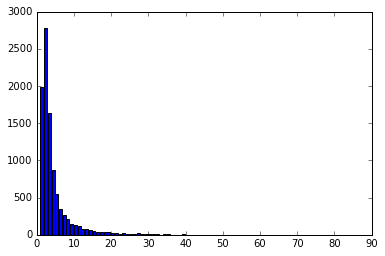

In [321]:
dd = nx.degree_histogram(G) 

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(np.arange(len(dd)),dd)
plt.show()

## Examine JEL subgraphs

In [126]:
# getJELSubgraph generates the subgraph of G containing all papers with 
# JEL code 'jelcode'
def getJELSubgraph(G, jelcode):
    SG = nx.Graph()
    sge = [e for e in G.edges(data=True) if jelcode in e[2]['jelcode']]
    SG.add_edges_from(sge)
    return SG

In [132]:
# getBigJELSubgraph generates the subgraph of G containing all papers with 
# JEL category (first letter) 'jelcode'
def getBigJELSubgraph(G, jelcode):
    SG = nx.Graph()
    sge = [e for e in G.edges(data=True) if jelcode in re.findall("[a-zA-Z]", e[2]['jelcode'])[0]]
    SG.add_edges_from(sge)
    return SG

In [ ]:
# Returns the Mean all-pairs node connectivity of a JEL Code
def getConnEst(G, jelcode):
    return np.mean(nx.all_pairs_node_connectivity(getJELSubgraph(G, jelcode)).values()[0].values()) 

In [123]:
# Get set of JEL super-categories (just first letter)
def getBigJELs(jels):
    bigJels = map(lambda x: re.findall("[a-zA-Z]",x)[0], jels)
    return set(bigJels)

In [124]:
# Get List of JEL codes
e = G.edges(data=True)
jels = set(','.join([x[2]['jelcode'] for x in e]).split(','))
bigJels = getBigJELs(jels)

# Get List of Nodes
n = G.nodes()
ndf = pd.DataFrame(n, columns=['author'])

In [182]:
# save coauthorship network for each JEL category
jelGraphs = {}
for currCode in bigJels:
    jelGraphs[currCode] = getBigJELSubgraph(G, currCode)
    nx.write_graphml(jelGraphs[currCode], '../save/jel' + currCode + '.graphml')

In [208]:
jeldf = summGraphList('bigJel',bigJels,jelGraphs)


In [235]:
jelGraphs['A']

## Examine institutional subgraphs 

In [ ]:
# Get list of NBER authors corresponding to Institution

instGraphs = {}
insts = department.Institution.unique()

# save coauthorship network for each institution
for currInst in insts:
    instGraphs[currInst] = G.subgraph(list(authDept[authDept.Institution == currInst].author))
    nx.write_graphml(instGraphs[currInst], \
                     '../save/' + currInst.replace(',','').replace(' ','_') + '.graphml')

In [ ]:
# Summarize Institutional Graphs

instDf = pd.DataFrame()
instDf['Institution'] = insts
instDf['Graph'] = instDf.Institution.apply(lambda x: instGraphs[x])
# Avg Degree, Avg Centrality, Number of Components, Number of Nodes, 
# Longest Shortest Path, Total # of Papers, Avg # of Papers, % of Papers within Dept
# Rank

instDf['AvgDegree'] = instDf.Graph.apply(lambda x: \
                                         np.mean(nx.degree(x, x.nodes()).values()))
instDf['nNodes'] = instDf.Graph.apply(lambda x: len(x.nodes()))

# Drop Empty Departments
instDf = instDf[instDf.nNodes != 0]

instDf['nCC'] = instDf.Graph.apply(lambda x: \
                                   len([c for c in nx.connected_components(x)]))
instDf['AvgSizeCC'] = instDf.Graph.apply(lambda x: \
                                         np.mean([len(c) for c in nx.connected_components(x)]))
instDf['MaxSizeCC'] = instDf.Graph.apply(lambda x: \
                                         np.max([len(c) for c in nx.connected_components(x)]))


In [ ]:
NBERPapers = pd.read_csv('../save/NBER_Paper_Info.1.csv', delimiter='|')

## Netflix feature matrix

- Pagerank
- JEL codes
- Geographic location (state, time zone) (prob time zone)
- Department

In [ ]:
# make a JEL lookup table to map jels to indices                                                     
jelLookup = dict()
for i, jel in enumerate(jels):
    jelLookup[jel] = i

# make an array of authors x JELs 
# to count how many papers in each JEL someone has
authors = nx.nodes(G)
authorCodes = np.zeros((len(authors), len(jels)))
for a in range(len(authors)):
    papers = G.edges(authors[a])
    for p in papers:
        paperAttrs = G.get_edge_data(p[0], p[1])
        paperJels  = paperAttrs['jelcode'].split(',')
        jelInds = [jelLookup[jel] for jel in paperJels]
        authorCodes[a, jelInds] += 1

In [ ]:
# PageRanks
ranks = nx.pagerank(G)

# add to graph                                                                  
nx.set_node_attributes(G, 'rank', ranks)

# in case we want to look at the top authors                                    
sortedRanks = sorted(ranks.items(), key=lambda x: x[1])

In [ ]:
# Extract PageRank to a vector                                                  
authors = G.nodes()
nodeRanks = np.empty(len(authors))
for i in range(len(authors)):
    nodeRanks[i] = ranks.get(authors[i])
nodeRanks = np.reshape(nodeRanks, (len(nodeRanks),1))

In [ ]:
# make feature dataframe
data = np.hstack((nodeRanks,authorCodes))
df = pd.DataFrame(data)
df.columns = ['rank'] + [jel for jel in jels]
df['author'] = authors

In [ ]:
df

In [ ]:
G.nodes(1)

#### TODO 

- Aggregate JELs by letter 
- Add JELS as author attributes.
- Look at degree distribution of subgraphs given by each JEL code